In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# ฟังก์ชันตรวจจับ Drip
def detect_drip(data, window=12, threshold=-0.05):
  drips = []
  for i in range(len(data) - window):
    # เพิ่มในฟังก์ชัน detect_drip
    if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
      continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
    
    close_price = data['close'].iloc[i]
    low_price = data['low'].iloc[i:i+window].min()
    drip_pct = (low_price - close_price) / close_price
    if drip_pct <= threshold:
      drips.append({
        'start_time': data.index[i],
        'close_price': close_price,
        'low_price': low_price,
        'drip_pct': drip_pct * 100,  # แปลงเป็น %
        'window_end_time': data.index[i+window-1]
      })
  
  return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))
drips = detect_drip(data, window=12, threshold=-0.05)

In [4]:
# เพิ่มคอลัมน์ปี
drips['year'] = drips['start_time'].dt.year

# 1. ค่าเฉลี่ยของขนาด Drip ในแต่ละปี
yearly_means = drips.groupby('year')['drip_pct'].mean().reset_index()
yearly_means.columns = ['Year', 'Mean Drip Size (%)']
print("\nMean Drip Size by Year:")
print(yearly_means.round(2))


Mean Drip Size by Year:
   Year  Mean Drip Size (%)
0  2017               -7.86
1  2018               -6.63
2  2019               -6.21
3  2020               -7.22
4  2021               -6.77
5  2022               -6.22
6  2023               -6.26
7  2024               -6.03
8  2025               -5.78


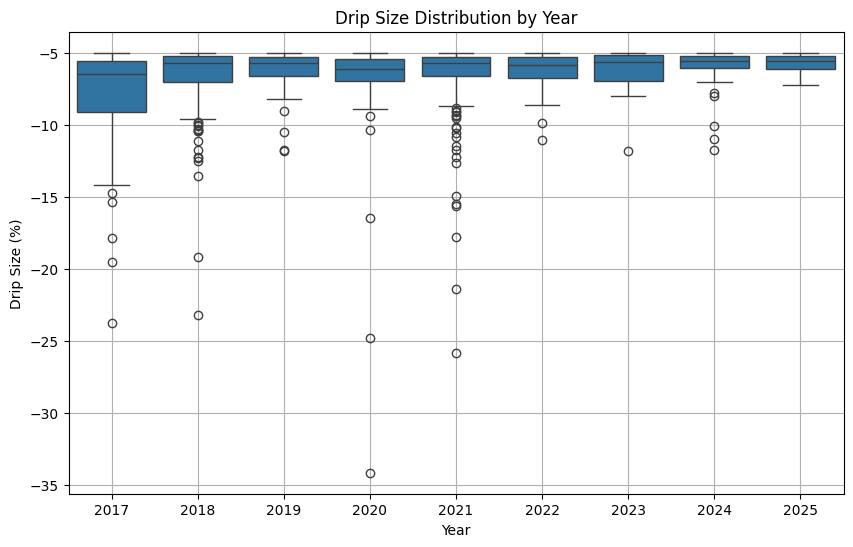

In [5]:
# สร้าง Boxplot เพื่อแสดงการกระจายของขนาด Drip ตามปี
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='drip_pct', data=drips)
plt.title('Drip Size Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Drip Size (%)')
plt.grid(True)
plt.show()

In [6]:
# 2. One-Way ANOVA Test: เปรียบเทียบค่าเฉลี่ยระหว่างทุกปี
if len(drips['year'].unique()) > 2:
    groups = [drips[drips['year'] == year]['drip_pct'] for year in drips['year'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nOne-Way ANOVA Test: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("There is a significant difference in mean Drip sizes between years (p < 0.05)")
    else:
        print("No significant difference in mean Drip sizes between years (p >= 0.05)")
else:
    print("\nANOVA Test: Not enough years to perform the test.")


One-Way ANOVA Test: F=3.8835, p-value=0.0002
There is a significant difference in mean Drip sizes between years (p < 0.05)


In [7]:
# 3. T-Test: เปรียบเทียบค่าเฉลี่ยระหว่างคู่ปี
print("\nT-Test Results (p-values for pairwise comparisons):")
t_test_results = []
year_pairs = list(itertools.combinations(drips['year'].unique(), 2))
for year1, year2 in year_pairs:
    group1 = drips[drips['year'] == year1]['drip_pct']
    group2 = drips[drips['year'] == year2]['drip_pct']
    if len(group1) > 1 and len(group2) > 1:  # ต้องมีข้อมูลเพียงพอ
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Year Pair': f'{year1} vs {year2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results (p-values for pairwise comparisons):
       Year Pair  T-Statistic  P-Value
0   2017 vs 2018      -3.5326   0.0005
1   2017 vs 2019      -3.8459   0.0002
2   2017 vs 2020      -1.0518   0.2945
3   2017 vs 2021      -2.7055   0.0073
4   2017 vs 2022      -3.9248   0.0001
5   2017 vs 2023      -1.8513   0.0667
6   2017 vs 2024      -3.4330   0.0008
7   2017 vs 2025      -2.5811   0.0111
8   2018 vs 2019      -1.4040   0.1616
9   2018 vs 2020       1.3065   0.1927
10  2018 vs 2021       0.4723   0.6370
11  2018 vs 2022      -1.4027   0.1620
12  2018 vs 2023      -0.6250   0.5327
13  2018 vs 2024      -1.6174   0.1073
14  2018 vs 2025      -1.5193   0.1304
15  2019 vs 2020       1.7948   0.0750
16  2019 vs 2021       1.5122   0.1319
17  2019 vs 2022       0.0594   0.9527
18  2019 vs 2023       0.1108   0.9120
19  2019 vs 2024      -0.6428   0.5217
20  2019 vs 2025      -1.2278   0.2229
21  2020 vs 2021      -0.8628   0.3892
22  2020 vs 2022      -1.8202   0.0710
23  2020 vs

In [8]:
# 4. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ยระหว่างทุกปี
if len(drips['year'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['drip_pct'], groups=drips['year'], alpha=0.05)
    print("\nTukey’s HSD Test Results:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough years to perform the test.")


Tukey’s HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  2017   2018   1.2313 0.0086  0.1818 2.2808   True
  2017   2019   1.6545 0.0028  0.3512 2.9578   True
  2017   2020   0.6469 0.8539 -0.6919 1.9857  False
  2017   2021   1.0923 0.0438  0.0155 2.1692   True
  2017   2022   1.6413 0.0028  0.3487  2.934   True
  2017   2023   1.6087 0.3919 -0.6432 3.8606  False
  2017   2024    1.835 0.0054   0.322  3.348   True
  2017   2025   2.0794 0.0648  -0.062 4.2207  False
  2018   2019   0.4232 0.9724 -0.7605 1.6069  False
  2018   2020  -0.5844 0.8615  -1.807 0.6383  False
  2018   2021   -0.139 0.9999 -1.0675 0.7896  False
  2018   2022     0.41 0.9758 -0.7619  1.582  False
  2018   2023   0.3774 0.9998 -1.8074 2.5623  False
  2018   2024   0.6037 0.9218 -0.8075  2.015  False
  2018   2025   0.8481 0.9385 -1.2227 2.9188  False
  2019   2020  -1.0076 0.4283  -2.454

In [9]:
# 5. F-Test: เปรียบเทียบความแปรปรวนระหว่างคู่ปี
print("\nF-Test Results (p-values for pairwise variance comparisons):")
f_test_results = []
for year1, year2 in year_pairs:
    group1 = drips[drips['year'] == year1]['drip_pct']
    group2 = drips[drips['year'] == year2]['drip_pct']
    if len(group1) > 1 and len(group2) > 1:
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        df1, df2 = len(group1) - 1, len(group2) - 1
        p_value = 1 - stats.f.cdf(f_stat, df1, df2)
        f_test_results.append({
            'Year Pair': f'{year1} vs {year2}',
            'F-Statistic': f_stat,
            'P-Value': p_value
        })
f_test_df = pd.DataFrame(f_test_results)
print(f_test_df.round(4))


F-Test Results (p-values for pairwise variance comparisons):
       Year Pair  F-Statistic  P-Value
0   2017 vs 2018       2.0808   0.0000
1   2017 vs 2019       5.6946   0.0000
2   2017 vs 2020       1.7238   0.0106
3   2017 vs 2021       1.3204   0.0616
4   2017 vs 2022       7.8702   0.0000
5   2017 vs 2023       3.6925   0.0032
6   2017 vs 2024       5.0014   0.0000
7   2017 vs 2025      24.9921   0.0000
8   2018 vs 2019       2.7367   0.0000
9   2018 vs 2020       3.5869   0.0000
10  2018 vs 2021       1.5759   0.0022
11  2018 vs 2022       3.7823   0.0000
12  2018 vs 2023       1.7745   0.1006
13  2018 vs 2024       2.4036   0.0006
14  2018 vs 2025      12.0108   0.0000
15  2019 vs 2020       9.8162   0.0000
16  2019 vs 2021       4.3128   0.0000
17  2019 vs 2022       1.3821   0.0888
18  2019 vs 2023       1.5422   0.1759
19  2019 vs 2024       1.1386   0.3276
20  2019 vs 2025       4.3888   0.0007
21  2020 vs 2021       2.2761   0.0000
22  2020 vs 2022      13.5665   0.0000
23

In [10]:
# 6. Levene’s Test: เปรียบเทียบความแปรปรวนระหว่างทุกปี
if len(drips['year'].unique()) > 2:
    groups = [drips[drips['year'] == year]['drip_pct'] for year in drips['year'].unique()]
    stat, p_value = stats.levene(*groups)
    print(f"\nLevene’s Test for Variance: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Variances are significantly different (p < 0.05)")
    else:
        print("No significant difference in variances (p >= 0.05)")
else:
    print("\nLevene’s Test: Not enough years to perform the test.")


Levene’s Test for Variance: stat=2.9944, p-value=0.0026
Variances are significantly different (p < 0.05)


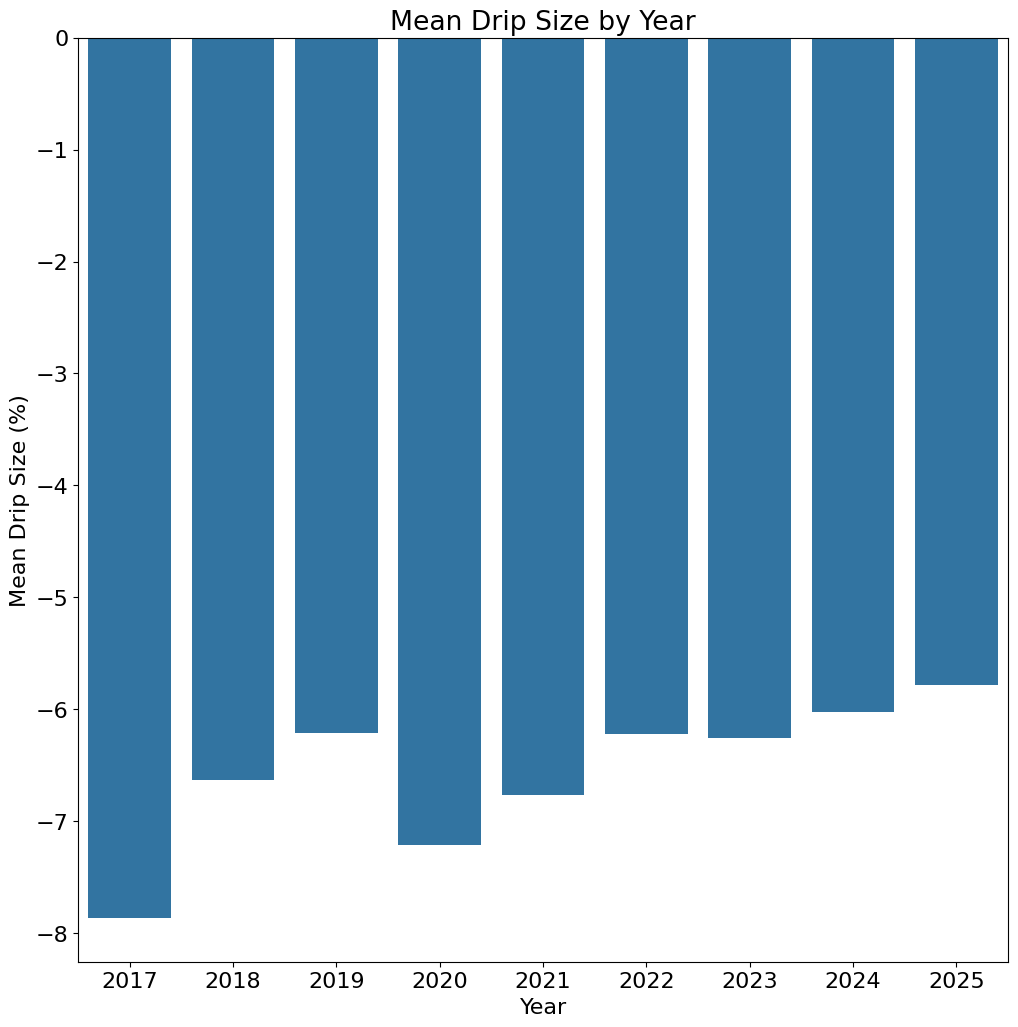

In [11]:
font = {'size': 16}
plt.rc('font', **font)

plt.figure(figsize=(12, 12))
sns.barplot(x='Year', y='Mean Drip Size (%)', data=yearly_means)
plt.title('Mean Drip Size by Year')
plt.show()